# 目的
- 基礎的な集計をする

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime as dt

# データの取得

In [2]:
def get_data(db_file='../data/choco-ball.db', table_name='measurement', filter_str=None):
    """
    dbファイルから計測データを取得する
    
    TODO:
        エラー処理を入れる
    """
    con = sqlite3.connect(db_file)
    sql = 'SELECT '
    sql += 'measure_date,best_before,prd_number,weight,box_weight,ball_number,factory,shop,angel,campaign,taste '
    sql += ', (weight - box_weight), (weight - box_weight)/ball_number '
    sql += 'FROM ' + table_name + ' '
    if filter_str is not None:
        sql += 'WHERE ' + filter_str
    sql += ';'
    sql_result = con.execute(sql)
    res = sql_result.fetchall()
    con.close()
    data = pd.DataFrame(res, columns=['measure_date','best_before','prd_number','weight','box_weight','ball_number','factory','shop','angel','campaign','taste','net_weight','mean_weight'])
    print 'Shape of MeasurementData(record_num, n_columns) : {}'.format(data.shape)
    return data

def get_date_str():
    tdatetime = dt.now()
    tstr = tdatetime.strftime('%Y-%m-%d')
    return tstr

# 基礎集計

In [3]:
def output_hist(data, plt_file, min_range=27.0, max_range=31.0, step=0.1, spec=28.0):
    b = np.arange(min_range, max_range, step)
    ret = plt.hist(data['net_weight'], 
                   bins=b, color="#0000FF", alpha=0.5, edgecolor="#0000FF", 
                   label='measure', normed=True)
    plt.vlines(x=spec, ymin=0, ymax=ret[0].max(), 
               colors='#FF0000', linewidths=2, label='spec')
    # 最尤推定パラメータの分布
    x = np.linspace(min_range, max_range, 300)
    y = stats.norm.pdf(x, loc=data['net_weight'].mean(), scale=data['net_weight'].std())
    plt.plot(x, y, lw=3, color='#0000FF', label='MLE')
    plt.legend()
    plt.xlabel('net weight [g]')
    plt.ylabel('frequency')
    #plt.savefig(plt_file)
    print 'save_figure : {}'.format(plt_file)

In [4]:
def main():
    db_file = '../data/choco-ball.db'
    table_name = 'measurement'
    filter_str = None#'taste=1'
    # 計測データ取得
    m_data = get_data(db_file=db_file, table_name=table_name, filter_str=filter_str)
    # ファイル名のラベルのために日付を取得
    t_str = get_date_str()
    # データ集計
    output_hist(data=m_data, plt_file='fig/base_hist_{}.png'.format(t_str))
    #output_hist(data=m_data, plt_file='fig/base_hist_{}.png'.format(t_str), min_range=24,max_range=29)
    # 表示用
    print '| 計測データ数 | {} |'.format(m_data.shape[0])
    print '| 銀のエンゼル出現数 | {} |'.format((m_data['angel']==1).sum())
    print '| 金のエンゼル出現数 | {} |'.format((m_data['angel']==2).sum())
    print('| 正味重量 | %2.3f | %2.3f | %2.3f | %2.3f |' % (
        (m_data['net_weight']).min(), (m_data['net_weight']).median(), 
        (m_data['net_weight']).max(), (m_data['net_weight']).mean()))
    print('| 個数 | %2.3f | %2.3f | %2.3f | %2.3f |' % (
        (m_data['ball_number']).min(), (m_data['ball_number']).median(), 
        (m_data['ball_number']).max(), (m_data['ball_number']).mean()))
    return m_data

Shape of MeasurementData(record_num, n_columns) : (61, 13)
save_figure : fig/base_hist_2017-12-24.png
| 計測データ数 | 61 |
| 銀のエンゼル出現数 | 1 |
| 金のエンゼル出現数 | 0 |
| 正味重量 | 24.011 | 29.389 | 31.681 | 29.136 |
| 個数 | 15.000 | 17.000 | 23.000 | 17.311 |


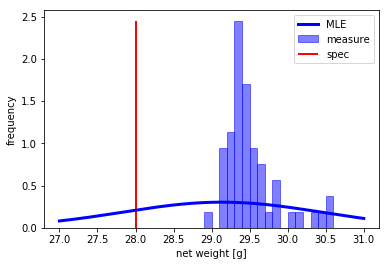

In [5]:
data = main()

# おまけ：味の違いを集計

In [6]:
data.shape

(61, 13)

In [13]:
g = data.groupby(['taste'])
specs = [28.0, 25.0, 29.0, 29.0, 22.0]

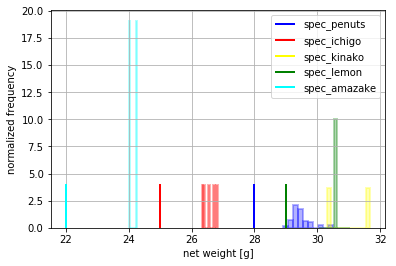

In [15]:
colors = ['blue', 'red', 'yellow', 'green', 'cyan']
cnt=0
for (key, group) in g:
    group['net_weight'].hist(color=colors[cnt], alpha=0.3, edgecolor=colors[cnt], lw=2, normed=True)
    cnt+=1
plt.vlines(x=specs[0], ymin=0, ymax=4, 
               colors=colors[0], linewidths=2, label='spec_penuts')
plt.vlines(x=specs[1], ymin=0, ymax=4, 
               colors=colors[1], linewidths=2, label='spec_ichigo')
plt.vlines(x=specs[2], ymin=0, ymax=4, 
               colors=colors[2], linewidths=2, label='spec_kinako')
plt.vlines(x=specs[3], ymin=0, ymax=4, 
               colors=colors[3], linewidths=2, label='spec_lemon')
plt.vlines(x=specs[4], ymin=0, ymax=4, 
               colors=colors[4], linewidths=2, label='spec_amazake')
plt.legend(loc="upper right")
plt.xlabel('net weight [g]')
plt.ylabel('normalized frequency')
plt.savefig('fig/basic_hist_three_taste.png')